<a href="https://colab.research.google.com/github/Du-nara/ME421-Mechanical-Systems-Lab-A3/blob/main/Vibration/E_20_249_Vibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity #1: Derivation of the 2-DOF Model

### 1. System Description
Based on the TM1016V manual, the 2-DOF system consists of the simply supported beam (acting as the primary mass) and the vibration absorber (acting as the secondary mass).

We define the generalized coordinates:
* $x_1(t)$: Vertical displacement of the beam's center (primary mass).
* $x_2(t)$: Vertical displacement of the vibration absorber (secondary mass).

### 2. System Parameters
Using the technical details provided in the user guide, we define the lumped parameters:

**Primary System (Beam + Exciter):**
* $m_1$: Effective mass of the beam system.
  $m_1 = m_{exciter} + m_{beam,eff}$
  *(Note: For a simply supported beam, the effective mass at the center is often approximated as half the total beam mass)*.
* $k_1$: Stiffness of the simply supported beam at the center.
  $k_1 = \frac{48EI}{L^3}$

**Secondary System (Absorber):**
* $m_2$: Mass of the vibration absorber.
* $k_2$: Stiffness of the absorber spring.

**Forcing Function:**
* [cite_start]$F(t)$: The harmonic force applied by the rotating unbalance in the exciter[cite: 543].
  $F(t) = F_0 \sin(\Omega t)$
  
  Where $F_0 = m_{unbalance} r \Omega^2$.

### 3. Free Body Diagrams & Equations of Motion
Applying Newton's Second Law to each mass:

**Mass 1 (Beam):**
The beam is subject to its own restoring force, the restoring force from the absorber spring (which pulls back), and the external excitation force.
$$m_1 \ddot{x}_1 = -k_1 x_1 + k_2(x_2 - x_1) + F(t)$$

**Mass 2 (Absorber):**
The absorber is driven solely by the coupling spring force connected to the beam.
$$m_2 \ddot{x}_2 = -k_2(x_2 - x_1)$$

### 4. Matrix Formulation
Rearranging the terms to group $x_1$ and $x_2$:

1. $m_1 \ddot{x}_1 + (k_1 + k_2)x_1 - k_2 x_2 = F(t)$
2. $m_2 \ddot{x}_2 - k_2 x_1 + k_2 x_2 = 0$

Writing this in matrix form $[M]\{\ddot{x}\} + [K]\{x\} = \{F\}$:

$$
\begin{bmatrix}
m_1 & 0 \\
0 & m_2
\end{bmatrix}
\begin{bmatrix}
\ddot{x}_1 \\
\ddot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
k_1 + k_2 & -k_2 \\
-k_2 & k_2
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
F_0 \sin(\Omega t) \\
0
\end{bmatrix}
$$

This model captures the two dominant modes of vibration corresponding to the in-phase and out-of-phase motion of the beam and the absorber.

# Activity #2: Estimating Damping Ratios

To estimate the damping ratios ($\zeta$) for the two dominant modes, we can use two primary methods depending on the data available (Time Domain vs. Frequency Domain).

### Method 1: Logarithmic Decrement (Time Domain)
[cite_start]According to the TM1016V User Guide, damping can be calculated by measuring the decay of oscillations. This is best used when the system is excited at a specific natural frequency and allowed to decay freely.

[cite_start]The **Logarithmic Decrement** ($\delta$) is defined as the natural log of the ratio of successive peak amplitudes ($x_0$ and $x_n$) separated by $n$ periods[cite: 513]:

$$\delta = \frac{1}{n} \ln \left( \frac{x_0}{x_n} \right)$$

The damping ratio ($\zeta$) is then derived from $\delta$:

$$\zeta = \frac{\delta}{\sqrt{4\pi^2 + \delta^2}} \approx \frac{\delta}{2\pi}$$
[cite_start]*(Note: The approximation holds for small damping ratios, typically $\zeta < 0.1$, which is expected for this steel beam apparatus)[cite: 513].*

### Method 2: Half-Power Bandwidth (Frequency Domain)
[cite_start]When observing the Frequency Response Function (FRF) — such as the magnification factor curves shown in Figure 19 of the manual  — we observe two distinct resonant peaks corresponding to the two modes.

We can estimate $\zeta$ using the **Half-Power Bandwidth** method:
1. Identify the peak frequency ($\omega_n$) and the peak amplitude ($X_{max}$).
2. Find the two frequencies ($\omega_1$ and $\omega_2$) on either side of the peak where the amplitude is $\frac{X_{max}}{\sqrt{2}}$ (approx. 0.707 of max amplitude).
3. Calculate $\zeta$:

$$\zeta \approx \frac{\omega_2 - \omega_1}{2\omega_n}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [2]:
# =============================
# REPLACE THESE WITH YOUR MODEL
# =============================
M = np.array([[1.0, 0.0],
              [0.0, 1.0]])

K = np.array([[100.0, -20.0],
              [-20.0, 50.0]])

# Force distribution vector (unbalanced motor)
b = np.array([[0.0],
              [1.0]])


In [3]:
zeta1 = 0.02
zeta2 = 0.02

# Natural frequencies
eigvals = np.linalg.eigvals(np.linalg.inv(M) @ K)
w = np.sqrt(np.sort(np.real(eigvals)))
w1, w2 = w

# Rayleigh damping
A = np.array([[1, w1**2],
              [1, w2**2]])
y = np.array([2*zeta1*w1, 2*zeta2*w2])
alpha, beta = np.linalg.solve(A, y)

C = alpha*M + beta*K


In [4]:
def simulate(M, C, K, f, x0, v0, t_end):
    Minv = np.linalg.inv(M)

    def ode(t, y):
        x = y[:2]
        v = y[2:]
        xdot = v
        vdot = Minv @ (f(t) - C @ v - K @ x)
        return np.hstack((xdot, vdot))

    t_eval = np.linspace(0, t_end, 3000)
    y0 = np.hstack((x0, v0))
    sol = solve_ivp(ode, [0, t_end], y0, t_eval=t_eval)
    return sol.t, sol.y[:2]


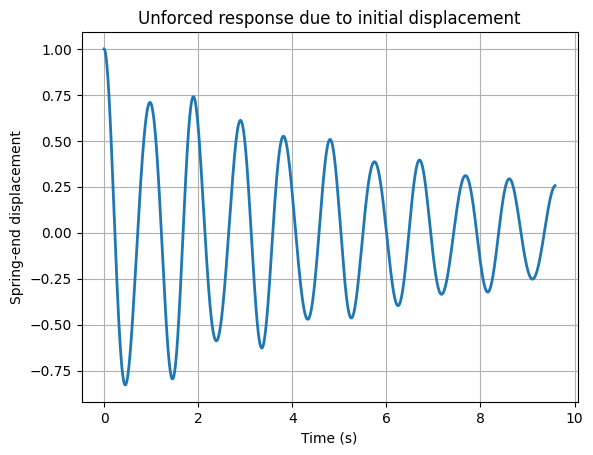

In [5]:
# Initial displacement at spring end (DOF 2)
x0 = np.array([0.0, 1.0])
v0 = np.array([0.0, 0.0])

f_zero = lambda t: np.zeros(2)

T1 = 2*np.pi/w1
t, x = simulate(M, C, K, f_zero, x0, v0, 10*T1)

plt.figure()
plt.plot(t, x[1], linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Spring-end displacement")
plt.title("Unforced response due to initial displacement")
plt.grid(True)
plt.show()


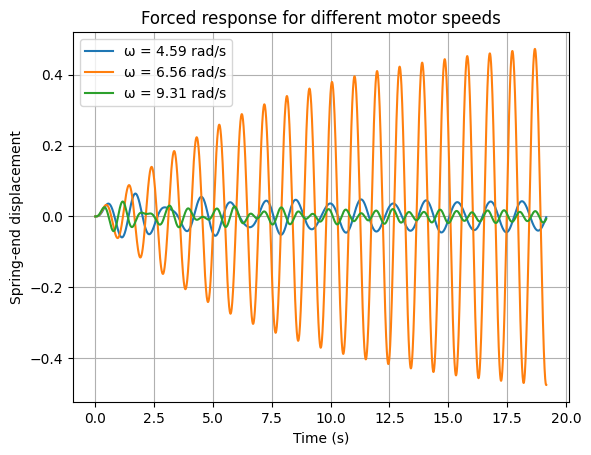

In [6]:
omegas = [0.7*w1, w1, 0.9*w2]
F0 = 1.0

plt.figure()

for om in omegas:
    f = lambda t, om=om: (b*F0*np.sin(om*t)).flatten()
    t, x = simulate(M, C, K, f, np.zeros(2), np.zeros(2), 20*T1)
    plt.plot(t, x[1], label=f"ω = {om:.2f} rad/s")

plt.xlabel("Time (s)")
plt.ylabel("Spring-end displacement")
plt.title("Forced response for different motor speeds")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-2607716003.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i] = np.linalg.solve(Z, b)[1]


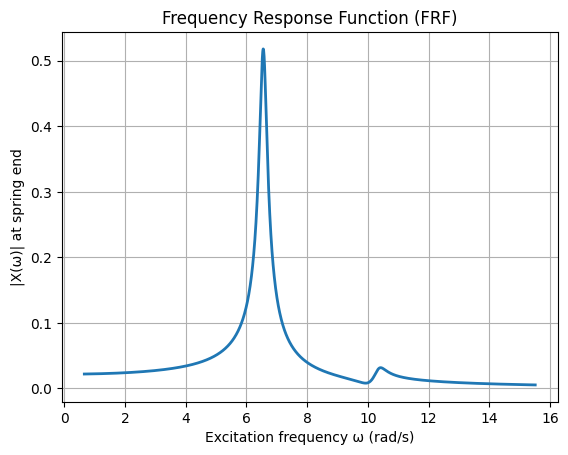

In [7]:
omega = np.linspace(0.1*w1, 1.5*w2, 2000)
X = np.zeros(len(omega), dtype=complex)

for i, om in enumerate(omega):
    Z = -om**2*M + 1j*om*C + K
    X[i] = np.linalg.solve(Z, b)[1]

plt.figure()
plt.plot(omega, np.abs(X), linewidth=2)
plt.xlabel("Excitation frequency ω (rad/s)")
plt.ylabel("|X(ω)| at spring end")
plt.title("Frequency Response Function (FRF)")
plt.grid(True)
plt.show()
